In [1]:
import pickle
import numpy as np

import torch
import torch.nn.functional as F
import torchmetrics

/vol/bitbucket/pn222/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("../")
sys.path.append("../imagen/")
sys.path.append("../../dataproc")

from utils import *

In [3]:
region = "West Pacific Ocean"
name = "Molave".replace(' ', '').lower()
start = 30

with open(f"./pkls/{region_to_abbv[region]}_{start:02}_{name}_forecast.pkl", "rb") as file:
    predictions_dict = pickle.load(file)

In [4]:
def SSIM(y_pred, y_true):
    y_pred = to3channel(y_pred.unsqueeze(0))
    y_true = to3channel(y_true.unsqueeze(0))
    ssim = torchmetrics.StructuralSimilarityIndexMeasure()
    output = ssim(y_pred, y_true)
    return output

In [5]:
ssim_seq = torch.empty(0, 1)
img_o = predictions_dict["actual"]["ir_108"][0]

for idx in range(predictions_dict["actual"]["ir_108"].shape[0]):
    y_true = predictions_dict["actual"]["ir_108"][idx]
    y_pred = predictions_dict["predicted"]["ir_108"][idx][0]

    y_true = normalize(y_true, img_o.max(), img_o.min())
    y_pred = normalize(y_pred, img_o.max(), img_o.min())

    ssim_seq = torch.cat([ssim_seq, SSIM(y_pred, y_true).reshape(1, 1)])

In [6]:
import matplotlib.pyplot as plt

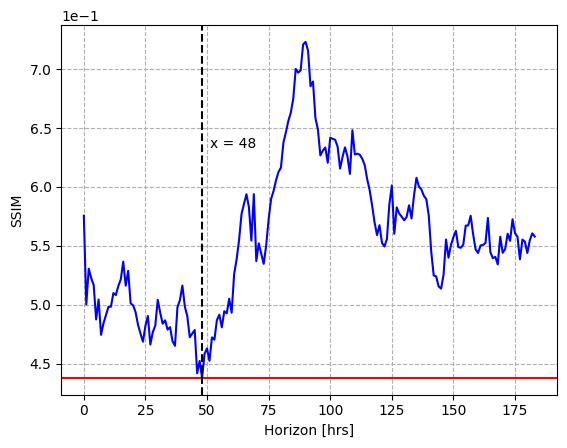

In [7]:
f = np.array(ssim_seq.flatten())
ssim_min = np.nanmin(f)
ssim_argmin = np.nanargmin(f)

x = np.array(range(len(ssim_seq)))
g = np.array([ssim_min.item() for i in x])

fig = plt.figure() ; ax = fig.gca()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.plot(f, c='b')

plt.axhline(y=ssim_min.item(), c='r')
plt.axvline(x=ssim_argmin, ls='--', c='k')
plt.text(x=ssim_argmin*1.07, 
         y=f[0]*1.1, 
         s=f"x = {ssim_argmin}")

plt.ylabel("SSIM")
plt.xlabel("Horizon [hrs]")
plt.grid(True, ls="--")

plt.savefig(f"./pngs/{region_to_abbv[region]}_{start:02}_{name}_horizon.png", bbox_inches="tight")